## Dynamic Programming - Production Planning
#### Stu.name = Amirali Khatib
#### Stu.id = 9722743149
#### Prof.name = Prof.Mohammad Ranjbar

In [1]:
import numpy as np
import pandas as pd

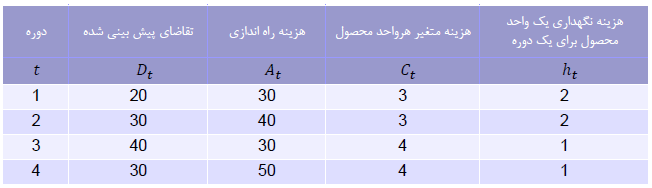

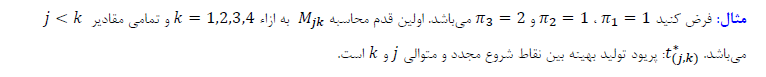

In [2]:
data = np.array([[1,20,30,3,1,0],
                 [2,30,40,3,2,5],
                 [3,40,30,4,5,1],
                 [4,30,50,2,1,2]])

In [3]:
def demand(data, now, since, until):
    now -= 1
    future = np.array([data[now+i-1,4] * np.sum(data[now + i:until, 1]) for i in range(1,until-now)])
    past   = np.array([data[now-i,5]   * np.sum(data[since:now - i, 1]) for i in range(0, now - since)])
    return np.sum(future) + np.sum(past)

In [4]:
def inventory_lost_cost(data,since,until):
    n_scenario = until - since
    il_cost = np.array([demand(data, since+i, since, until) for i in range(1,n_scenario + 1)])
    return il_cost

In [5]:
def manufacturing_cost(data,since,until):
    n_scenario = until - since
    m_cost = np.array([(data[since + i, 2] + data[since + i, 3] * np.sum(data[since:until,1]) ) for i in range(n_scenario)])
    return m_cost 

In [6]:
def M_calculator(data, since, until):
    if since >= until: return np.nan
    else:
        m = list(manufacturing_cost(data,since,until) + inventory_lost_cost(data,since,until))
        return len(range(since)) * [np.nan] + m + (len(data) - until) * [np.nan]

In [7]:
def one_array(list1): return [y for x in list1 for y in x]

In [8]:
def table1(data):
    start_b = one_array([((len(data) - t) * [t]) for t in range(len(data))])
    start_a = one_array([list(range(1+i, len(data)+1)) for i in range(len(data))])
    table = []
    for since, until in zip(start_b, start_a): table.append(M_calculator(data, since, until))
    table = np.array(table)
    dict_table = {}
    dict_table['j'] = start_b
    dict_table['k'] = start_a
    for t in range (1, len(data)+1): dict_table[str(t)] = list(table[:,t - 1])
    dict_table['M(j,k)'] = [np.nanmin(table[i,:]) for i in range(len(table))]
    dict_table['t(j,k)'] = [int(np.array(list(range(1,len(data)+1)))[table[i,:] == np.nanmin(table[i,:])]) for i in range(len(table))]    
    return pd.DataFrame(dict_table)

In [9]:
table1(data)

,j,k,1,2,3,4,"M(j,k)","t(j,k)"
0,0,1,90.0,NaN,NaN,NaN,90.0,1
1,0,2,210.0,290.0,NaN,NaN,210.0,1
2,0,3,450.0,490.0,540.0,NaN,450.0,1
3,0,4,780.0,790.0,810.0,620.0,620.0,4
4,1,2,NaN,130.0,NaN,NaN,130.0,2
5,1,3,NaN,330.0,340.0,NaN,330.0,2
6,1,4,NaN,630.0,610.0,420.0,420.0,4
7,2,3,NaN,NaN,190.0,NaN,190.0,3
8,2,4,NaN,NaN,460.0,270.0,270.0,4
9,3,4,NaN,NaN,NaN,110.0,110.0,4


In [10]:
filter1 =table1(data).loc[:,['j','k','M(j,k)','t(j,k)']]
filter1

,j,k,"M(j,k)","t(j,k)"
0,0,1,90.0,1
1,0,2,210.0,1
2,0,3,450.0,1
3,0,4,620.0,4
4,1,2,130.0,2
5,1,3,330.0,2
6,1,4,420.0,4
7,2,3,190.0,3
8,2,4,270.0,4
9,3,4,110.0,4


In [11]:
def fill(LIST, VALUE,ind):
    for i in range(len(LIST[:ind])):
        if LIST[i] > VALUE: LIST[i] = VALUE
    return LIST

def corrector(List):
    for i in range(1,len(List)):
        if List[i] < List[i-1]:
            List = fill(List,List[i],i)
        else: continue
    return np.array(List)

In [12]:
def table2(data,filter1):
    f0 = 0
    table2_array = np.array(len(data)* [np.nan])
    for t in range(len(data)):
        added_array = np.full(t,np.nan)
        if t == 0: update = list(filter1[filter1['j'] == t].iloc[:,2] + f0)
        else: update = list(filter1[filter1['j'] == t].iloc[:,2] + np.nanmin(table2_array[:,:],axis = 0)[t-1])         
        added_array = np.append(added_array, update)
        table2_array = np.vstack((table2_array, added_array))
    table2_array = np.delete(table2_array, 0, 0)
    table2_array = np.vstack((table2_array, np.nanmin(table2_array,axis = 0)))
    j_array = np.array([float(np.argwhere(table2_array[:len(data),t] == np.nanmin(table2_array[:len(data),t]))[-1]) for t in range(len(data))])
    table2_array = np.vstack((table2_array,j_array))
    table2_df = pd.DataFrame(table2_array,
                             index = [str(i) for i in range(len(data))] + ['F','j'],
                             columns = [str(i) for i in range(1, len(data)+1)])
    return table2_df  

In [13]:
table2(data,filter1)


,1,2,3,4
0,90.0,210.0,450.0,620.0
1,NaN,220.0,420.0,510.0
2,NaN,NaN,400.0,480.0
3,NaN,NaN,NaN,510.0
F,90.0,210.0,400.0,480.0
j,0.0,0.0,2.0,2.0


In [14]:
def planner(DATA):
    TABLE1 = table1(DATA)
    FILTER = TABLE1.loc[:,['j','k','M(j,k)','t(j,k)']]
    TABLE2 = table2(DATA,FILTER)
    
    print('======================M-TABLE======================\n',
          TABLE1,
          '\n\n',
          '======================F-TABLE======================\n',
          TABLE2,'\n\n',
          '=======================Output======================\n')
    time = list(np.unique(corrector(list(table2(data, FILTER).loc['j']))))
    time.append(len(DATA))
    time = list(np.array(time).astype(int))
    for i in range(len(time)): 
        if i+1>=len(time):
            break
        else:
            print(f'[{time[i]},{time[i+1]}] ===> X{int(FILTER[(FILTER.j == time[i]) & (FILTER.k == time[i+1])].iloc[:,3])}* = {np.sum(DATA[time[i]:time[i+1], 1])}')        
    print(f'Z* = {TABLE2.iloc[len(TABLE2)-2][len(TABLE2.columns)-1]}')
    return None

In [15]:
planner(data)

======================M-TABLE======================
    j  k      1      2      3      4  M(j,k)  t(j,k)
0  0  1   90.0    NaN    NaN    NaN    90.0       1
1  0  2  210.0  290.0    NaN    NaN   210.0       1
2  0  3  450.0  490.0  540.0    NaN   450.0       1
3  0  4  780.0  790.0  810.0  620.0   620.0       4
4  1  2    NaN  130.0    NaN    NaN   130.0       2
5  1  3    NaN  330.0  340.0    NaN   330.0       2
6  1  4    NaN  630.0  610.0  420.0   420.0       4
7  2  3    NaN    NaN  190.0    NaN   190.0       3
8  2  4    NaN    NaN  460.0  270.0   270.0       4
9  3  4    NaN    NaN    NaN  110.0   110.0       4 

 ======================F-TABLE======================
       1      2      3      4
0  90.0  210.0  450.0  620.0
1   NaN  220.0  420.0  510.0
2   NaN    NaN  400.0  480.0
3   NaN    NaN    NaN  510.0
F  90.0  210.0  400.0  480.0
j   0.0    0.0    2.0    2.0 

 =======================Output======================

[0,2] ===> X1* = 50
[2,4] ===> X4* = 70
Z* = 480.0


In [16]:
import numpy as np
import pandas as pd


data = np.array([[1,20,30,3,1,0],
                 [2,30,40,3,2,5],
                 [3,40,30,4,5,1],
                 [4,30,50,2,1,2]])


#def data_builder(length):
#    np.random.seed(123)# 12, 8 , 
#    period = np.array([t for t in range(1,length+1)])
#    demand = np.array([np.random.randint(10,60) for t in range(length)])
#    setup_cost = np.array([np.random.randint(10,60) for t in range(length)])
#    production_cost = np.array([np.random.randint(4,11) for t in range(length)])
#    holding_cost = np.array([np.random.randint(1,4) for t in range(length)])
#    backorder_cost = np.array([np.random.randint(1,4) for t in range(length)])
#    return np.column_stack((period, demand, setup_cost, production_cost, holding_cost, backorder_cost))

#data = data_builder(8)

def demand(data, now, since, until):
    now -= 1
    future = np.array([data[now+i-1,4] * np.sum(data[now + i:until, 1]) for i in range(1,until-now)])
    past   = np.array([data[now-i,5]   * np.sum(data[since:now - i, 1]) for i in range(0, now - since)])
    return np.sum(future) + np.sum(past)

def inventory_lost_cost(data,since,until):
    n_scenario = until - since
    il_cost = np.array([demand(data, since+i, since, until) for i in range(1,n_scenario + 1)])
    return il_cost

def manufacturing_cost(data,since,until):
    n_scenario = until - since
    m_cost = np.array([(data[since + i, 2] + data[since + i, 3] * np.sum(data[since:until,1]) ) for i in range(n_scenario)])
    return m_cost 

def M_calculator(data, since, until):
    if since >= until: return np.nan
    else:
        m = list(manufacturing_cost(data,since,until) + inventory_lost_cost(data,since,until))
        return len(range(since)) * [np.nan] + m + (len(data) - until) * [np.nan]

def one_array(list1): return [y for x in list1 for y in x]


def table1(data):
    start_b = one_array([((len(data) - t) * [t]) for t in range(len(data))])
    start_a = one_array([list(range(1+i, len(data)+1)) for i in range(len(data))])
    table = []
    for since, until in zip(start_b, start_a): table.append(M_calculator(data, since, until))
    table = np.array(table)
    dict_table = {}
    dict_table['j'] = start_b
    dict_table['k'] = start_a
    for t in range (1, len(data)+1): dict_table[str(t)] = list(table[:,t - 1])
    dict_table['M(j,k)'] = [np.nanmin(table[i,:]) for i in range(len(table))]
    dict_table['t(j,k)'] = [int(np.array(list(range(1,len(data)+1)))[table[i,:] == np.nanmin(table[i,:])]) for i in range(len(table))]    
    return pd.DataFrame(dict_table)


def fill(LIST, VALUE,ind):
    for i in range(len(LIST[:ind])):
        if LIST[i] > VALUE: LIST[i] = VALUE
    return LIST

def corrector(List):
    for i in range(1,len(List)):
        if List[i] < List[i-1]:
            List = fill(List,List[i],i)
        else: continue
    return np.array(List)

def table2(data,filter1):
    f0 = 0
    table2_array = np.array(len(data)* [np.nan])
    for t in range(len(data)):
        added_array = np.full(t,np.nan)
        if t == 0: update = list(filter1[filter1['j'] == t].iloc[:,2] + f0)
        else: update = list(filter1[filter1['j'] == t].iloc[:,2] + np.nanmin(table2_array[:,:],axis = 0)[t-1])         
        added_array = np.append(added_array, update)
        table2_array = np.vstack((table2_array, added_array))
    table2_array = np.delete(table2_array, 0, 0)
    table2_array = np.vstack((table2_array, np.nanmin(table2_array,axis = 0)))
    j_array = np.array([float(np.argwhere(table2_array[:len(data),t] == np.nanmin(table2_array[:len(data),t]))[-1]) for t in range(len(data))])
    table2_array = np.vstack((table2_array,j_array))
    table2_df = pd.DataFrame(table2_array,
                             index = [str(i) for i in range(len(data))] + ['F','j'],
                             columns = [str(i) for i in range(1, len(data)+1)])
    return table2_df

def planner(DATA):
    TABLE1 = table1(DATA)
    FILTER = TABLE1.loc[:,['j','k','M(j,k)','t(j,k)']]
    TABLE2 = table2(DATA,FILTER)
    
    print('======================M-TABLE======================\n',
          TABLE1,
          '\n\n',
          '======================F-TABLE======================\n',
          TABLE2,'\n\n',
          '=======================Output======================\n')
    time = list(np.unique(corrector(list(table2(data, FILTER).loc['j']))))
    time.append(len(DATA))
    time = list(np.array(time).astype(int))
    for i in range(len(time)): 
        if i+1>=len(time):
            break
        else:
            print(f'[{time[i]},{time[i+1]}] ===> X{int(FILTER[(FILTER.j == time[i]) & (FILTER.k == time[i+1])].iloc[:,3])}* = {np.sum(DATA[time[i]:time[i+1], 1])}')        
    print(f'Z* = {TABLE2.iloc[len(TABLE2)-2][len(TABLE2.columns)-1]}')
    return None

planner(data)

======================M-TABLE======================
    j  k      1      2      3      4  M(j,k)  t(j,k)
0  0  1   90.0    NaN    NaN    NaN    90.0       1
1  0  2  210.0  290.0    NaN    NaN   210.0       1
2  0  3  450.0  490.0  540.0    NaN   450.0       1
3  0  4  780.0  790.0  810.0  620.0   620.0       4
4  1  2    NaN  130.0    NaN    NaN   130.0       2
5  1  3    NaN  330.0  340.0    NaN   330.0       2
6  1  4    NaN  630.0  610.0  420.0   420.0       4
7  2  3    NaN    NaN  190.0    NaN   190.0       3
8  2  4    NaN    NaN  460.0  270.0   270.0       4
9  3  4    NaN    NaN    NaN  110.0   110.0       4 

 ======================F-TABLE======================
       1      2      3      4
0  90.0  210.0  450.0  620.0
1   NaN  220.0  420.0  510.0
2   NaN    NaN  400.0  480.0
3   NaN    NaN    NaN  510.0
F  90.0  210.0  400.0  480.0
j   0.0    0.0    2.0    2.0 

 =======================Output======================

[0,2] ===> X1* = 50
[2,4] ===> X4* = 70
Z* = 480.0
